In [2]:
import os
import gc
import math

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.animation as animation
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

# les animations au format MP4 nécessitent ffmepg.exe pour être produites
plt.rcParams['animation.ffmpeg_path'] ='C:\\Program Files\\ffmpeg\\bin\\ffmpeg.exe'

# Lecture des données squelettes

Les données des squelettes sont stockées sous format CSV (séparateur espace).
25 lignes stockent les données issues des 25 articulations enregistrées par Kinect.
Ces données présentent :
- les coordonnées 3D (x y z),
- les coordonnées du squelette dans l'image IR (depthX, depthY),
- les coordonnées du squelette dans l'image RGB (colorX, colorY),
- l'orientation (x y z w) des articulations
- l'état du capteur

Les coordonnées du squelettes x, y, z sont comprises respectivement entre:
- [-1, 1] pour x et y ([0, 0] étant le centre du champ de vision de la caméra)
- [0, 4,5+-4] pour z (le capteur Kinect peut détecter des objets jusqu'à 8 mètres de profondeur mais il n'est réellement efficace que jusqu'à 4,5m)

(cf. https://medium.com/@lisajamhoury/understanding-kinect-v2-joints-and-coordinate-system-4f4b90b9df16

 cf. https://github.com/shahroudy/NTURGB-D/blob/master/Matlab/read_skeleton_file.m)

Les squelettes enregistres 25 articulations ainsi distribuées :

![skeleton](./references/kinectv2_skeleton.png)

In [197]:
# Joint names du Kinect v2
joint_names = [
    "spinebase",
    "spinemid", 
    "neck", 
    "head", 
    "shoulderleft", 
    "elbowleft", 
    "wristleft", 
    "handtipleft", 
    "shoulderright", 
    "elbowright", 
    "wristright", 
    "handtipright", 
    "hipleft", 
    "kneeleft", 
    "ankleleft", 
    "footleft", 
    "hipright", 
    "kneeright", 
    "ankleright", 
    "footright", 
    "spineshoulder", 
    "handtipleft", 
    "thumbleft", 
    "handtipright",  
    "thumbright" 
]
# Os entre les articulations (d'après l'index de joint_names)
bones = [
    [3, 2],
    [2, 20],
    [20, 1],
    [1, 0],
    [0, 12],
    [12, 13],
    [13, 14],
    [14, 15],
    [0, 16],
    [16, 17],
    [17, 18],
    [18, 19],
    [20, 4],
    [4, 5],
    [5, 6],
    [6, 7],
    [7, 21],
    [6, 22],
    [20, 8],
    [8, 9],
    [9, 10],
    [10, 11],
    [11, 23],
    [10, 24]
]

# Lecture des données

In [198]:
label = "A017"
data = pd.read_csv(f"data/videos/nturgb+d_skeletons/S001C001P001R001{label}.skeleton", header=None)

In [199]:
data.head(30)

,0
0,134
1,1
2,72057594037931706 0 0 0 0 0 0 -0.1697937 0.112...
3,25
4,0.3590623 -0.0960513 4.206793 287.5685 216.847...
5,0.3317847 0.1562067 4.114841 285.8418 194.6097...
6,0.3036734 0.4021834 4.012763 284.0484 171.8093...
7,0.2843681 0.518865 3.978842 282.5224 160.7372 ...
8,0.1907373 0.3268229 4.091011 273.4032 179.2721...
9,0.147887 0.1219779 4.117317 269.4796 197.6646 ...


## Supression des données non pertinentes

In [200]:
# on ne conserve que les données dont la taille démontre qu'il s'agit de nombres flottants
data['length'] = data[0].apply(lambda x: len(x))
cond = data['length'] > 10
data = data[cond]
# ré-indexage
data = data.reset_index(drop=True)
# suppression des en-têtes de frame
data = data[data.index % 26 != 0]
# supression de la column de tri par la longueur
data = data.drop(columns=['length'])
# ré-indexage
data = data.reset_index(drop=True)
# formattage des données numériques
data = data[0].str.split(" ", expand=True)
data = data.fillna(method='bfill')
# noms des variables
data.columns = ["x", "y", "z", "depthX", "depthY", "colorX", "colorY", "orientW", "orientX", "orientY", "orientZ", "trackingState"]
data["jointName"] = joint_names * (len(data) // 25)
# frames
data["frame"] = [j for j in range(len(data) // 25) for i in range(25)]
data.head(30)

,x,y,z,depthX,depthY,colorX,colorY,orientW,orientX,orientY,orientZ,trackingState,jointName,frame
0,0.3590623,-0.0960513,4.206793,287.5685,216.8472,1063.859,591.4846,-0.2060453,-0.01395593,0.9617188,-0.1801319,2,spinebase,0
1,0.3317847,0.1562067,4.114841,285.8418,194.6097,1059.341,527.2891,-0.2264528,-0.01012167,0.957119,-0.180388,2,spinemid,0
2,0.3036734,0.4021834,4.012763,284.0484,171.8093,1054.629,461.5231,-0.2444445,-0.003125936,0.944984,-0.217353,2,neck,0
3,0.2843681,0.518865,3.978842,282.5224,160.7372,1050.387,429.6254,0,0,0,0,2,head,0
4,0.1907373,0.3268229,4.091011,273.4032,179.2721,1023.602,482.9218,0.2507493,0.7454435,-0.6175247,-0.01009253,2,shoulderleft,0
5,0.147887,0.1219779,4.117317,269.4796,197.6646,1012.059,535.9678,0.119419,0.4293326,0.01238866,0.8951308,2,elbowleft,0
6,0.04031,-0.02711493,4.229866,259.8315,210.8386,983.7023,573.945,0.3742004,0.8261302,-0.1189817,0.4041366,2,wristleft,0
7,0.02018139,-0.02688572,4.231707,258.0913,210.8178,978.6647,573.8723,0.6181036,0.4018621,-0.3515928,0.5769206,2,handtipleft,0
8,0.4159444,0.3180784,3.962597,294.7753,179.1097,1085.703,482.6819,-0.09331086,0.67626,0.6347204,-0.3620712,2,shoulderright,0
9,0.3949582,0.1176521,3.977146,292.682,197.6722,1079.525,536.1871,0.05686187,0.1497217,0.02786187,0.9866985,2,elbowright,0


## Visualisation

In [201]:
frames = [0, 25, 50]

xs0 = np.array(data[data.frame == frames[0]].x, dtype="float32")
ys0 = np.array(data[data.frame == frames[0]].y, dtype="float32")
zs0 = np.array(data[data.frame == frames[0]].z, dtype="float32")

xs1 = np.array(data[data.frame == frames[1]].x, dtype="float32")
ys1 = np.array(data[data.frame == frames[1]].y, dtype="float32")
zs1 = np.array(data[data.frame == frames[1]].z, dtype="float32")

xs2 = np.array(data[data.frame == frames[2]].x, dtype="float32")
ys2 = np.array(data[data.frame == frames[2]].y, dtype="float32")
zs2 = np.array(data[data.frame == frames[2]].z, dtype="float32")

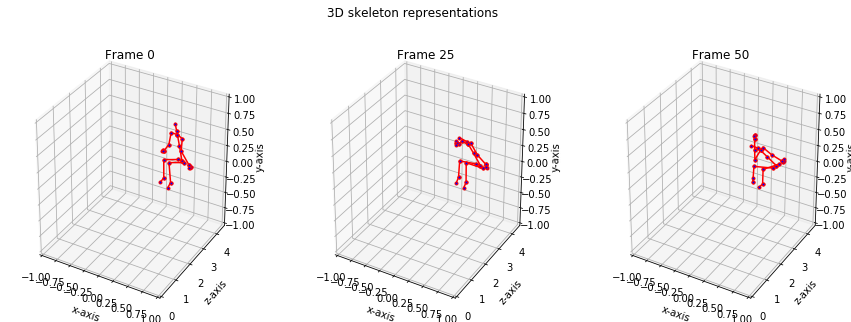

In [203]:
# inverser y et z : z représente la distance à la caméra et non une altitude

fig = plt.figure(figsize=(15, 5))
fig.suptitle("3D skeleton representations")
ax0 = fig.add_subplot(131, projection="3d", xlim=(-1, 1), ylim=(0, 4.5), zlim=(-1, 1))
ax1 = fig.add_subplot(132, projection="3d", xlim=(-1, 1), ylim=(0, 4.5), zlim=(-1, 1))
ax2 = fig.add_subplot(133, projection="3d", xlim=(-1, 1), ylim=(0, 4.5), zlim=(-1, 1))

ax0.set_xlabel('x-axis') 
ax0.set_ylabel('z-axis') 
ax0.set_zlabel('y-axis')
ax0.set_title(f'Frame {frames[0]}')

ax1.set_xlabel('x-axis') 
ax1.set_ylabel('z-axis') 
ax1.set_zlabel('y-axis')
ax1.set_title(f'Frame {frames[1]}')

ax2.set_xlabel('x-axis') 
ax2.set_ylabel('z-axis') 
ax2.set_zlabel('y-axis')
ax2.set_title(f'Frame {frames[2]}')

for bone in bones:
    ax0.plot([xs0[bone[0]], xs0[bone[1]]], [zs0[bone[0]], zs0[bone[1]]], [ys0[bone[0]], ys0[bone[1]]], 'r', marker='o', mfc='b', ms=3)
    ax1.plot([xs1[bone[0]], xs1[bone[1]]], [zs1[bone[0]], zs1[bone[1]]], [ys1[bone[0]], ys1[bone[1]]], 'r', marker='o', mfc='b', ms=3)
    ax2.plot([xs2[bone[0]], xs2[bone[1]]], [zs2[bone[0]], zs2[bone[1]]], [ys2[bone[0]], ys2[bone[1]]], 'r', marker='o', mfc='b', ms=3)

plt.savefig("reports/dataset/3d_skeletons_A17.png")

# Matrices de distance

In [204]:
def distance_matrix(x, y, z, matrix=None, reduce=True):
    """
    Compute distance matrix.
    
    Args:
        x, y, z: coordonates of points
         matrix: matrix to update, if already built
         reduce: reduce matrix coeffs in [0, 1]
     
    Return:
        matrix: distance matrix
    """
    assert x.size == y.size == z.size
    nb_pt = x.size
    if matrix is None:
        matrix = np.zeros((25, 25), dtype="float32")
    
    for i in range(nb_pt):
        for j in range(nb_pt):
            matrix[i, j] = math.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2)
            
    if reduce:
        matrix = (matrix - matrix.min()) / matrix.max()
        
    return matrix

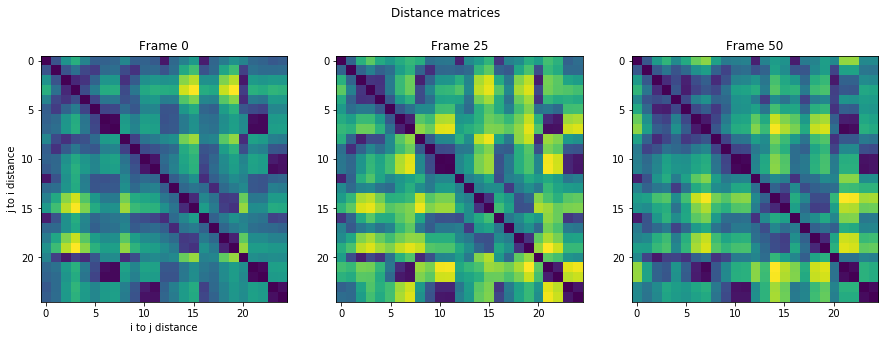

In [205]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle("Distance matrices")
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

ax0.set_xlabel('i to j distance') 
ax0.set_ylabel('j to i distance') 
ax0.set_title(f'Frame {frames[0]}')

ax1.set_title(f'Frame {frames[1]}')

ax2.set_title(f'Frame {frames[2]}')

ax0.imshow(distance_matrix(xs0, ys0, zs0))
ax1.imshow(distance_matrix(xs1, ys1, zs1))
ax2.imshow(distance_matrix(xs2, ys2, zs2))

plt.savefig("reports/dataset/mat_dist_A17.png")

# Animation

https://www.geeksforgeeks.org/graph-plotting-python-set-3/

In [ ]:
def animate_skeleton(skeleton, save_path, label="Skeleton", matrix=True):
    """
    Create an animation of a skeleton and matrix distance.
    
    Args:
        skeleton: dataframe containing skeleton's points
        save_path: video path
        label: title
        matrix: if true, distance matrix is also computed
    """
    if matrix:
        subplots = [(121), (122)]
    else:
        subplots = [(111)]
    
    X = np.array(skeleton.x, dtype="float32")
    Y = np.array(skeleton.y, dtype="float32")
    Z = np.array(skeleton.z, dtype="float32")
    
    fig = plt.figure(figsize=(15, 7)) 
    fig.suptitle(label)
    
    ax1 = fig.add_subplot(subplots[0],xlim=(-1, 1), ylim=(-1, 1))
    lines = [ax1.plot([], [], 'b', marker='o', mfc="r")[0] for bone in bones]

    if matrix:
        ax2 = fig.add_subplot(subplots[1])
        image = ax2.matshow(np.zeros((25, 25), dtype="float32"), vmin=0, vmax=1)

    # initialization function 
    def init(): 
        xs = X[0:25]
        ys = Y[0:25]
        zs = Z[0:25]
         
        for bone, line in zip(bones, lines):
            line.set_data([xs[bone[0]], xs[bone[1]]], [ys[bone[0]], ys[bone[1]]])
        
        if matrix:
            matrix = image.get_array()
            image.set_array(distance_matrix(xs, ys, zs, matrix=matrix))
            return line, image
        else:
            return line,

    # animation function (for frame: i)
    def animate(i): 
        xs = X[i*25:(i+1)*25]
        ys = Y[i*25:(i+1)*25]
        zs = Z[i*25:(i+1)*25]     

        for bone, line in zip(bones, lines):
            line.set_data([xs[bone[0]], xs[bone[1]]], [ys[bone[0]], ys[bone[1]]]) 
        
        if matrix:
            matrix = image.get_array()
            image.set_array(distance_matrix(xs, ys, zs, matrix=matrix))
            
            return line, image
        else:
            return line,

  
    anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                   frames=X.size // 25, interval=20, blit=True) 

    FFwriter=animation.FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
    anim.save(save_path, writer=FFwriter) 

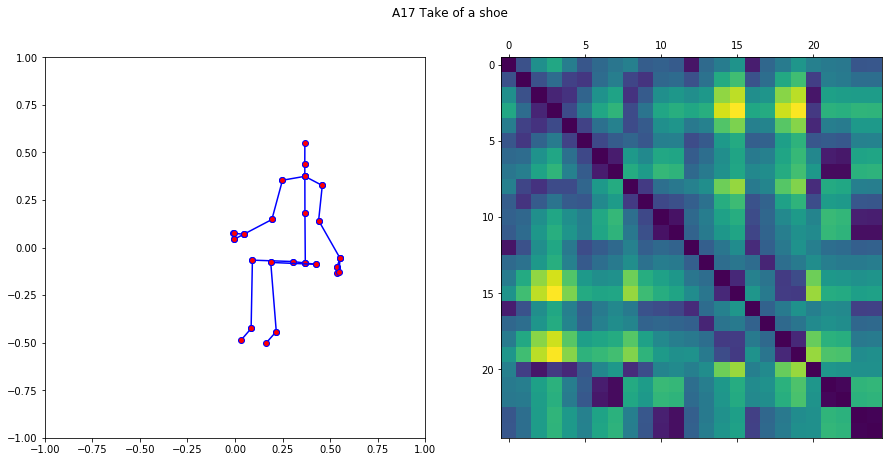

In [189]:
animate_skeleton(data, "./reports/dataset/A17_demo.mp4", label="A17 Take of a shoe")